# Now we are going to test and implement more advanced machine learning algorithms

In [1]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
import matplotlib.pyplot as plt
import numpy as np
import os, pandas, warnings
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

Seed = 72993
np.random.seed(Seed)
nJobs = 2

warnings.filterwarnings("ignore")

# Load our data similar to before
## This time we will do cross-validation on the training set so we will only need training and validation

In [2]:
parameters = pandas.read_csv("Dipeptides_Judred.csv", index_col=0)
#print(parameters)
targets = pandas.read_csv("APs.csv", index_col = 0)
#print(targets)

Forcefield = "2.1"
targets = targets[targets["FF"] == Forcefield]
targets.index = targets["pep"]

targets = targets["mean"]
X_train, X_val, y_train, y_val = train_test_split(parameters, targets, test_size=0.33, random_state=9876, shuffle=True)
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=9876, shuffle=True)

#### We will now perform hyperparameter optimization for several models and rank them against each other. Due to limit time we are keeping the number of combinations of hyperparameters relatively small but you can play around with it to make further improvements.

Due to the way Jupyter notebooks works, dont move onto the next block of code after running a hyperparameter optimization until you see the console print: "Best params from grid search: ...."

# SVM rbf

In [3]:
# Define the hyperparameters we want to test
SVRrbf_param_grid = {
        "kernel": ["rbf"],
        "gamma": ["scale", "auto"],
        "C": [0.1, 1, 10, 100], 
        "epsilon": np.linspace(0.1, 1, 10), 
        "max_iter": [-1],
        "tol": [0.01, 0.001, 0.0001], 
        "verbose":[0]}

In [4]:
model = SVR()
HPO_model = GridSearchCV(estimator = model, param_grid = SVRrbf_param_grid, cv = 5, n_jobs = nJobs, verbose = True)
HPO_model.fit(X_train.values, y_train.values.reshape(-1))
print("\nBest params from grid search:")
print(HPO_model.best_params_)
SVMrbf_hyperparameters = HPO_model.best_params_
    

Fitting 5 folds for each of 240 candidates, totalling 1200 fits

Best params from grid search:
{'C': 100, 'epsilon': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'tol': 0.001, 'verbose': 0}


# Random forest

In [5]:
RF_param_grid = {'bootstrap': [True, False],
                  'criterion': ['squared_error', 'absolute_error'],
                  'max_depth': [None],
                  'max_features': ["sqrt", "log2", None],
                  'max_leaf_nodes': [None],
                  'min_impurity_decrease': [0.0],
                  'min_samples_leaf': [1, 2],
                  'min_samples_split': [0.5, 1.0],
                  'min_weight_fraction_leaf': [0.0, 0.01, 0.1],
                  'n_estimators': [10, 100],
                  'n_jobs': [nJobs],
                  'oob_score': [False],
                  'verbose': [False],
                  'warm_start': [False, True],
                  "random_state":[Seed]}

In [6]:
model = RandomForestRegressor()

HPO_model = GridSearchCV(estimator=model, param_grid=RF_param_grid, cv = 5, n_jobs = nJobs, verbose = True)
HPO_model.fit(X_train.values, y_train.values.reshape(-1))
print("\nBest params from grid search:")
print(HPO_model.best_params_)
RF_hyperparameters = HPO_model.best_params_


Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Best params from grid search:
{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 0.5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 2, 'oob_score': False, 'random_state': 72993, 'verbose': False, 'warm_start': False}


In [7]:
print(RF_hyperparameters)

{'bootstrap': True, 'criterion': 'squared_error', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 2, 'min_samples_split': 0.5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': 2, 'oob_score': False, 'random_state': 72993, 'verbose': False, 'warm_start': False}


# Deep Neural Network

In [8]:
MLP_param_grid = {
        "activation": ["relu"],
        "alpha":[0.0001, 0.1],
        "batch_size": [20],
        "early_stopping":[True],
        #epsilon
        "hidden_layer_sizes": [(10,), (10,2), (10,3)] + [(100,), (100,2), (100,3)],
        "learning_rate":["adaptive"],
        "learning_rate_init": [0.001],
        "max_iter":[100, 1000],
        #momentum
        #"power_t":[0.25, 0.5, 0.75], 
        "random_state":[Seed], 
        "shuffle":[False], 
        "solver": ["sgd", "adam"],
        "tol": [0.01, 0.1], 
        "validation_fraction":[0.1],
        "n_iter_no_change": [5, 10],
        "verbose":[0]}

In [9]:
model = MLPRegressor()
HPO_model = GridSearchCV(estimator = model, param_grid = MLP_param_grid, cv = 5, n_jobs = nJobs, verbose = True)
HPO_model.fit(X_train.values, y_train.values.reshape(-1))

print("\nBest params from grid search:")
print(HPO_model.best_params_)
MLP_hyperparameters = HPO_model.best_params_

Fitting 5 folds for each of 192 candidates, totalling 960 fits

Best params from grid search:
{'activation': 'relu', 'alpha': 0.0001, 'batch_size': 20, 'early_stopping': True, 'hidden_layer_sizes': (100,), 'learning_rate': 'adaptive', 'learning_rate_init': 0.001, 'max_iter': 100, 'n_iter_no_change': 10, 'random_state': 72993, 'shuffle': False, 'solver': 'adam', 'tol': 0.01, 'validation_fraction': 0.1, 'verbose': 0}


# Test and compare

In [10]:
SVMmodel = SVR(**SVMrbf_hyperparameters)
RFmodel = RandomForestRegressor(**RF_hyperparameters)
DNNmodel = MLPRegressor(**MLP_hyperparameters)

SVMmodel.fit(X_train, y_train)
RFmodel.fit(X_train, y_train)
DNNmodel.fit(X_train, y_train)

SVM_predictions = SVMmodel.predict(X_val)
RF_predictions = RFmodel.predict(X_val)
DNN_predictions = DNNmodel.predict(X_val)

SVM_rmse = mean_squared_error(y_val, SVM_predictions, squared=False)
RF_rmse = mean_squared_error(y_val, RF_predictions, squared=False)
DNN_rmse = mean_squared_error(y_val, DNN_predictions, squared=False)

print("Support vector machine RMSE:", SVM_rmse)
print("Random forest RMSE:", RF_rmse)
print("Deep neural network RMSE:", DNN_rmse)



Support vector machine RMSE: 0.12316831827379227
Random forest RMSE: 0.21960715310652
Deep neural network RMSE: 0.18654543219669056


# Visualize the comparison

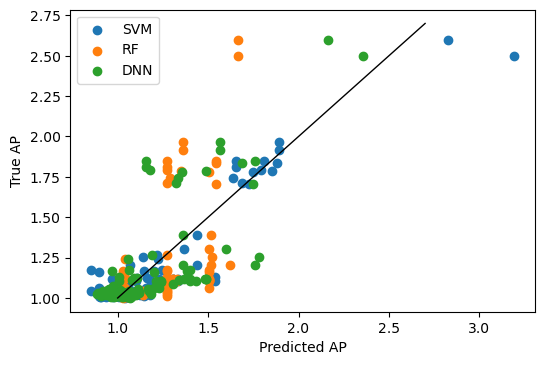

In [11]:
plt.scatter(SVM_predictions, y_val, label="SVM")
plt.scatter(RF_predictions, y_val, label="RF")
plt.scatter(DNN_predictions, y_val, label="DNN")

plt.plot([1,2.7], [1,2.7], lw=1, c="black")
plt.xlabel("Predicted AP")
plt.ylabel("True AP")
plt.gcf().set_dpi(100)
plt.legend()
plt.show()

# Re-weighting
## Since we have an unbalanced dataset we may wish to give more weight to those with high AP (few) over those with a low AP (many) - especially since these are the more interesting ones.

Support vector machine RMSE: 0.1252762749563625
Random forest RMSE: 0.22603582717519133


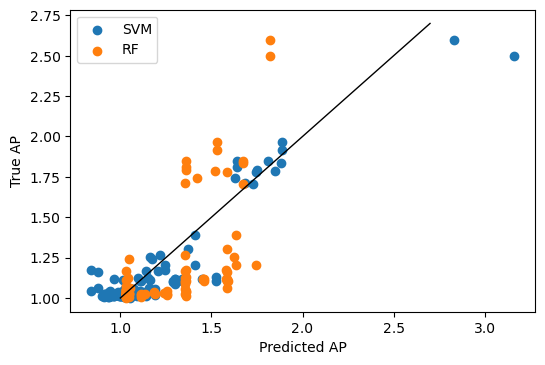

In [12]:
SVMmodel.fit(X_train, y_train, sample_weight = y_train-0.5)
RFmodel.fit(X_train, y_train, sample_weight = y_train-0.5)


SVM_predictions = SVMmodel.predict(X_val)
RF_predictions = RFmodel.predict(X_val)


SVM_rmse = mean_squared_error(y_val, SVM_predictions, squared=False)
RF_rmse = mean_squared_error(y_val, RF_predictions, squared=False)


print("Support vector machine RMSE:", SVM_rmse)
print("Random forest RMSE:", RF_rmse)

plt.scatter(SVM_predictions, y_val, label="SVM")
plt.scatter(RF_predictions, y_val, label="RF")

plt.plot([1,2.7], [1,2.7], lw=1, c="black")
plt.xlabel("Predicted AP")
plt.ylabel("True AP")
plt.gcf().set_dpi(100)
plt.legend()
plt.show()


# Challenge

## 1 implement and optimize a different machine learning model, such as the [Extra Trees Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)

In [13]:
from sklearn.ensemble import ExtraTreesRegressor
#...

## 2 Add an additional parameters to the dataset to see if it can contribute to better AP predictions

In [14]:
#parameters["new parameter"] = function(peptide)